In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# Detect encoding for the kaggle dataset

In [45]:
df = pd.read_csv('all_seasons.csv')
df.drop(columns=df.columns[0], inplace=True)
df = df[df['season'].isin(['2019-20', '2020-21', '2021-22'])]
df.head()
df.tail()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
12300,Tobias Harris,PHI,29.0,200.66,102.511792,Tennessee,USA,2011,1,19,...,17.2,6.8,3.5,3.2,0.032,0.164,0.214,0.566,0.158,2021-22
12301,Tomas Satoransky,WAS,30.0,200.66,95.254320,NaN,Czech Republic,2012,2,32,...,3.6,2.3,3.3,-8.0,0.029,0.110,0.124,0.461,0.285,2021-22
12302,Tony Bradley,CHI,24.0,208.28,112.490816,North Carolina,USA,2017,1,28,...,3.0,3.4,0.5,5.2,0.123,0.196,0.128,0.600,0.065,2021-22
12303,Tony Snell,NOP,30.0,198.12,96.615096,New Mexico,USA,2013,1,20,...,3.5,1.9,0.5,-7.8,0.018,0.107,0.099,0.541,0.047,2021-22
12304,Terry Rozier,CHA,28.0,185.42,86.182480,Louisville,USA,2015,1,16,...,19.3,4.3,4.5,1.4,0.021,0.101,0.227,0.566,0.197,2021-22


In [46]:
def extract_feature(column,X_train,y_train,X_test,y_test):
    df_feature_train = X_train.sort_values([column],ascending=[True]).groupby(column).apply(lambda df: pd.DataFrame(np.array([[df.age.values[-1], np.mean(df.gp.values), np.mean(df.pts.values), df.pts.values[-1], df.pts.values[-2], np.mean(df.net_rating.values), np.mean(df.ts_pct.values), np.mean(df.usg_pct.values), df['season_index'].values[-1]]])))
    x_feature_train = df_feature_train.values
    labels_train = y_train.sort_values([column],ascending=[True]).pts.values

    df_feature_test = X_test.sort_values([column],ascending=[True]).groupby(column).apply(lambda df: pd.DataFrame(np.array([[df.age.values[-1], np.mean(df.gp.values), np.mean(df.pts.values), df.pts.values[-1], df.pts.values[-2], np.mean(df.net_rating.values), np.mean(df.ts_pct.values), np.mean(df.usg_pct.values), df['season_index'].values[-1]]])))
    x_feature_test = df_feature_test.values
    labels_test = y_test.sort_values([column],ascending=[True]).pts.values
    return x_feature_train,labels_train,x_feature_test,labels_test


In [47]:
def preprocess_data(dataframe, augment_data, minimum_records=3, segment_length=5):
    # Getting unique player info and assigning IDs
    player_unique_values = dataframe[["player_name", "player_height", "player_weight"]].drop_duplicates()
    player_unique_values = player_unique_values.reset_index(drop=True)
    player_unique_values.reset_index(inplace=True)
    player_unique_values.rename(columns={"index": "PlayerID"}, inplace=True)
    
    # Merging to get a combined dataset and dropping some unnecessary columns
    combined_data = pd.merge(player_unique_values, dataframe, on=["player_name", "player_height", "player_weight"])
    combined_data.drop(columns=["player_name", "draft_year"], inplace=True)
    
    # Filtering players with enough records and sorting
    grouped_data = combined_data.groupby('PlayerID').filter(lambda x: len(x) >= minimum_records)
    grouped_data.sort_values(by=["PlayerID", "season"], ascending=[True, True])
    grouped_data.drop(columns=["season"], inplace=True)
    
    # Adding season index and total seasons per player
    grouped_data["season_index"] = grouped_data.groupby("PlayerID").cumcount() + 1
    grouped_data["seasons_total"] = grouped_data.groupby("PlayerID")["PlayerID"].transform("count")
    final_dataset = grouped_data.reset_index(drop=True)
    
    # If augmenting data, create segments for each player
    if augment_data:
        data_segments = []
        segment_counter = 0
        for player_id, data_group in final_dataset.groupby("PlayerID"):
            group_length = len(data_group)
            data_group = data_group.reset_index(drop=True)
            if group_length > segment_length:
                for i in range(group_length-segment_length+1):
                    data_segment = data_group.loc[i:i+segment_length-1].copy()
                    data_segment["segment_id"] = segment_counter
                    data_segments.append(data_segment)
                    segment_counter += 1
            else:       
                data_group["segment_id"] = segment_counter
                data_segments.append(data_group)
                segment_counter += 1
        final_dataset = pd.concat(data_segments).reset_index(drop=True)
        identifier_column = "segment_id"
    else:
        identifier_column = "PlayerID"
    
    # Splitting dataset into training and testing
    split_ratio = 0.8
    ids = final_dataset[[identifier_column]].drop_duplicates().values.flatten()
    total_ids = len(ids)
    np.random.shuffle(ids)
    training_ids = ids[:int(total_ids * split_ratio)]
    testing_ids = ids[int(total_ids * split_ratio):]
    training_dataset = pd.concat([final_dataset[final_dataset[identifier_column] == id] for id in training_ids])
    testing_dataset = pd.concat([final_dataset[final_dataset[identifier_column] == id] for id in testing_ids])
    training_dataset.to_csv(f'./dataset/training_dataset_{identifier_column}.csv', index=False)
    testing_dataset.to_csv(f'./dataset/testing_dataset_{identifier_column}.csv', index=False)
    
    # Reading back the split datasets
    training_data = pd.read_csv(f"./dataset/training_dataset_{identifier_column}.csv", index_col=False)
    testing_data = pd.read_csv(f"./dataset/testing_dataset_{identifier_column}.csv", index_col=False)
    
    # Preparing features and labels for training and testing
    training_features = training_data.groupby(identifier_column).apply(lambda x: pd.DataFrame(x[0:-1])).reset_index(drop=True)
    training_labels = training_data.groupby(identifier_column).apply(lambda x: pd.DataFrame(x[len(x)-1:len(x)])).reset_index(drop=True)
    
    testing_features = testing_data.groupby(identifier_column).apply(lambda x: pd.DataFrame(x[0:-1])).reset_index(drop=True)
    testing_labels = testing_data.groupby(identifier_column).apply(lambda x: pd.DataFrame(x[len(x)-1:len(x)])).reset_index(drop=True)
    
    # Extracting features and labels
    features_train, labels_train, features_test, labels_test = extract_feature(identifier_column, training_features, training_labels, testing_features, testing_labels)
    
    # Scaling the features
    data_scaler = StandardScaler()
    data_scaler.fit(features_train)
    features_train_scaled = data_scaler.transform(features_train)
    features_test_scaled = data_scaler.transform(features_test)
    return features_train_scaled, labels_train, features_test_scaled, labels_test


MSE score on testing data: 14.544712758129295
MSE score on training data: 13.976747017270064


RMSE score on testing data: 3.8137531066036896
RMSE score on training data: 3.738548784925785


R^2 score on testing data: 0.6201260365670954
R^2 score on training data: 0.6249242821317862


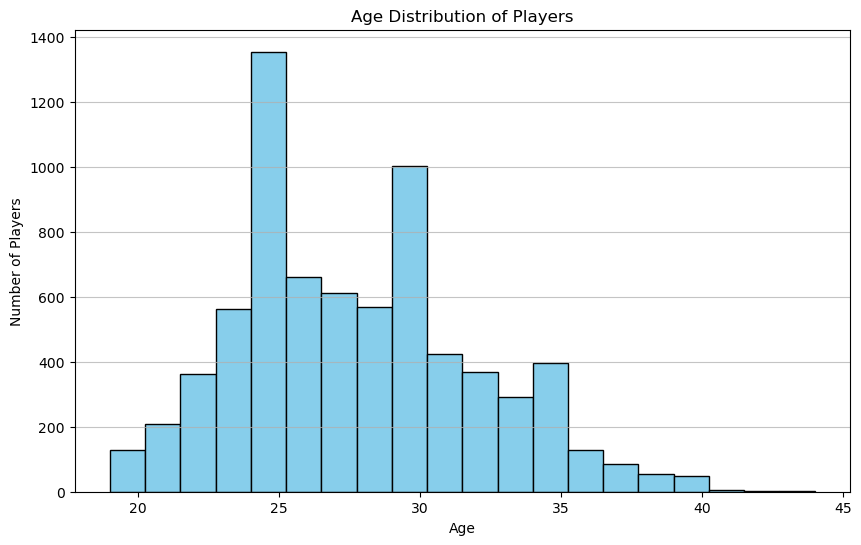

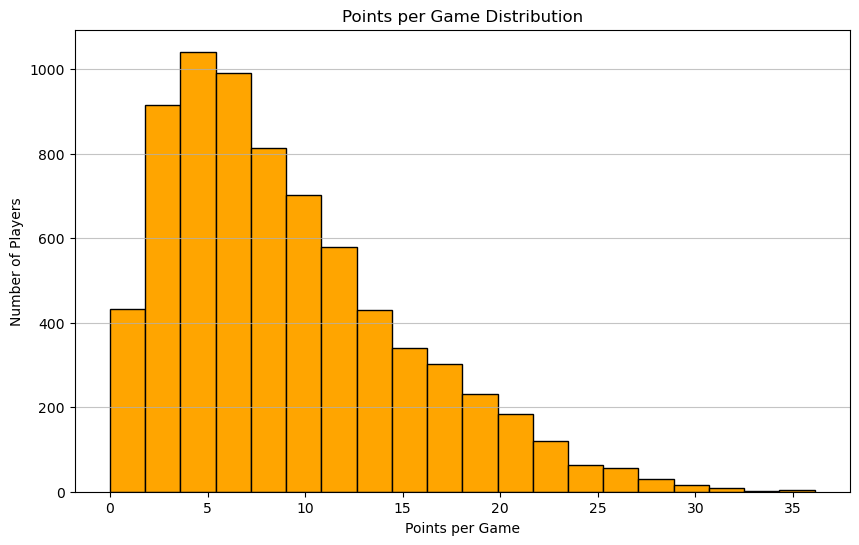

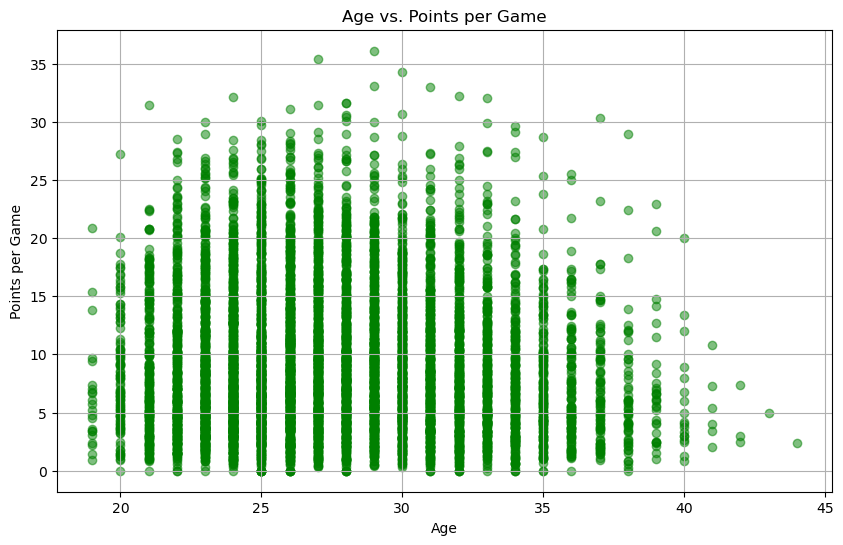

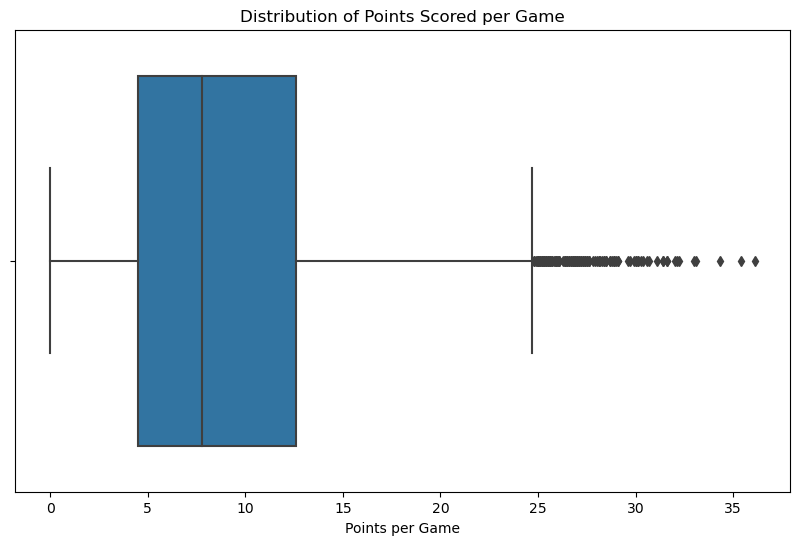

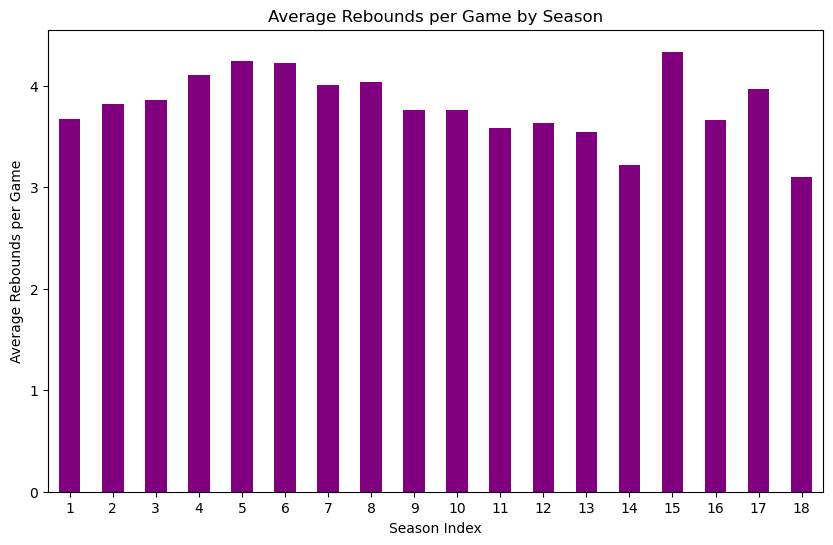

In [54]:
# Import necessary libraries for linear regression, metrics, and preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

df = pd.read_csv('all_seasons.csv')
# Preprocess the data to get training and testing sets
features_train, targets_train, features_test, targets_test = preprocess_data(df, 0, segment_length=6)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model with the training data
linear_model.fit(features_train, targets_train)

# Make predictions on the testing and training datasets
predictions_test_linear = linear_model.predict(features_test)
predictions_train_linear = linear_model.predict(features_train)

# Calculate the Mean Squared Error for both testing and training datasets
mse_test_linear = mean_squared_error(targets_test, predictions_test_linear)
mse_train_linear = mean_squared_error(targets_train, predictions_train_linear)

# Print the MSE for both testing and training to evaluate the model
print("MSE score on testing data:", mse_test_linear)
print("MSE score on training data:", mse_train_linear)
print("\n")

print("RMSE score on testing data:", mse_test_linear**0.5)
print("RMSE score on training data:", mse_train_linear**0.5)
print("\n")

# Calculate R^2 score for testing and training datasets
r2_test_linear = r2_score(targets_test, predictions_test_linear)
r2_train_linear = r2_score(targets_train, predictions_train_linear)

# Print the R^2 scores for both testing and training datasets
print("R^2 score on testing data:", r2_test_linear)
print("R^2 score on training data:", r2_train_linear)



# Load the dataset
df = pd.read_csv("./dataset/training_dataset_PlayerID.csv")

#visualizations to better understand the training data set 

# Plotting Age Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.grid(axis='y', alpha=0.75)

# Plotting Points per Game
plt.figure(figsize=(10, 6))
plt.hist(df['pts'], bins=20, color='orange', edgecolor='black')
plt.title('Points per Game Distribution')
plt.xlabel('Points per Game')
plt.ylabel('Number of Players')
plt.grid(axis='y', alpha=0.75)

# Relationship between Age and Points per Game
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['pts'], color='green', alpha=0.5)
plt.title('Age vs. Points per Game')
plt.xlabel('Age')
plt.ylabel('Points per Game')
plt.grid(True)

# Create a simple box plot for the 'pts' column
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.boxplot(x=df['pts'])
plt.title('Distribution of Points Scored per Game')  # Adding a title to the plot
plt.xlabel('Points per Game')  # Labeling the x-axis


# Average Rebounds per Game by Season
rebounds_by_season = df.groupby('season_index')['reb'].mean()
plt.figure(figsize=(10, 6))
rebounds_by_season.plot(kind='bar', color='purple')
plt.title('Average Rebounds per Game by Season')
plt.xlabel('Season Index')
plt.ylabel('Average Rebounds per Game')
plt.xticks(rotation=0)





plt.show()
